## Integrate the Sensor and Simulation Data

In [1]:
# Grid and domainfile
gridfile = 'drive/MyDrive/grid.pkl'

# EPA data
infile_epa = 'drive/MyDrive/epa_chicago_20230626.csv'

# Purple Air data
infile_ppl = 'drive/MyDrive/purpleair_chicago_20230626.csv'

# Model data
infile_sim = 'drive/MyDrive/sim_data20230626.txt'

# PPL to EPA parameter file
file_ppl2epa ='drive/MyDrive/ppl2epa.pkl'

## Set up the Google Colab Environment

In [2]:
pip install gpcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.2/285.2 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.7/593.7 kB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 27.5 MB/s eta 0:00:00
  Created wheel for zmq: filename=zmq-0.0.0-py3-none-any.whl size=1264 sha2

In [3]:
pip install ipyleaflet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 6.5 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Read Datasets

In [5]:
import pandas as pd
import numpy as np
import pickle

In [6]:
# Purple Air data
df_ppl = pd.read_csv(infile_ppl)

In [7]:
# EPA data
df_epa=pd.read_csv(infile_epa)

In [8]:
# Plume prediction data
sim = np.loadtxt(infile_sim)

In [9]:
# Grid
f = open(gridfile,"rb")
grid = pickle.load(f)
f.close()

In [10]:
# Purple Air to EPA data
f = open(file_ppl2epa,"rb")
ppl2epa = pickle.load(f)
f.close()

## Define the measurement uncertainty and merge data

In [11]:
# EPA data is assumed to be ground-truth
df_epa['var_err'] = np.zeros(df_epa.shape[0])

In [12]:
## Purple Air Error Variance
df_ppl['var_err'] = np.zeros(df_ppl.shape[0])  + ppl2epa['err']**2
df_ppl['AQI'] = df_ppl['AQI']*ppl2epa['slope'] + ppl2epa['intercept']

In [13]:
df=pd.concat([df_epa,df_ppl],join='inner')

## Create Grid

In [14]:
import matplotlib.pyplot as plt
import scipy

In [15]:
def loc2elem(loc, grid):
    nx = np.floor((loc[:,0]-grid['sw'][0]) / grid['d_pts'][0]) + 1
    ny = np.floor((loc[:,1]-grid['sw'][1])/ grid['d_pts'][1]) + 1

    nx[(nx < 1) | (nx > grid['n_pts'][0])] = np.nan
    ny[(ny < 1) | (ny > grid['n_pts'][1])] = np.nan

    n = (ny - 1) * grid['n_pts'][0] + nx

    return n.astype(int)

In [16]:
# Training data
x = np.column_stack((np.array(df['Latitude']),np.array(df['Longitude'])))
y = np.array(df['AQI'])

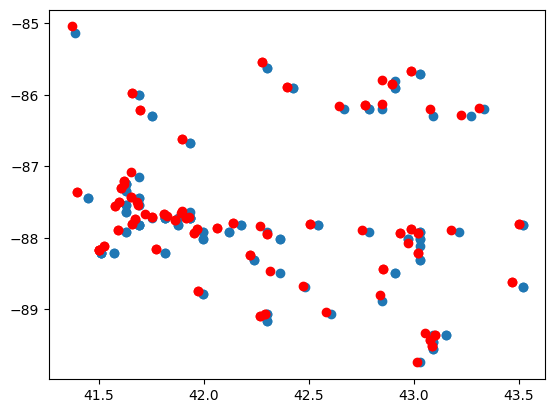

In [19]:
# Location check
ix =  loc2elem(x, grid)
plt.plot(grid['xx0'].flatten()[ix],grid['xx1'].flatten()[ix],'o')
plt.plot(x[:,0],x[:,1],'ro')

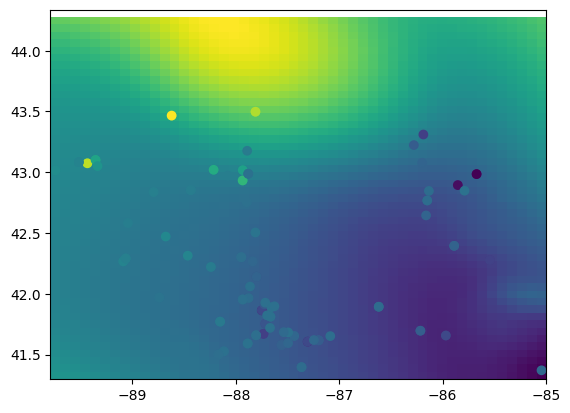

In [20]:
plt.pcolormesh(grid['xx1'],grid['xx0'],sim, cmap="viridis")
plt.scatter(x[:,1],x[:,0],c=y,cmap='viridis')

## Regression

In [21]:
from scipy import stats

In [22]:
# Simulation vs EPA data
ix =  loc2elem(x, grid)
ysim=sim.flatten()[ix]
idx_epa = np.where(df['var_err']==0.0)
idx_ppl = np.where(df['var_err']>0.0)

slope, intercept, r_value, p_value, std_err = stats.linregress(ysim[idx_epa],y[idx_epa], )
val = intercept + slope*ysim
r   = y - val

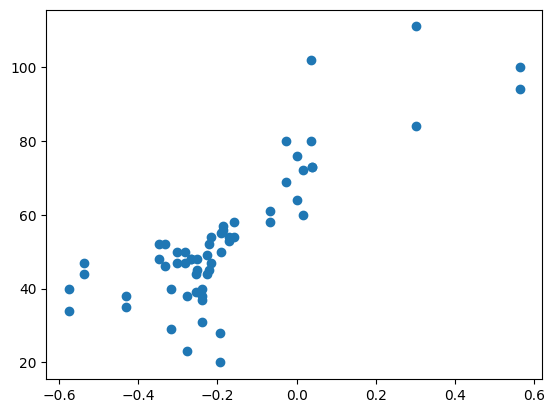

In [23]:
plt.plot(ysim[idx_epa],y[idx_epa],'o')

## Interpolate with GPCAM

In [24]:
import gpcam
from gpcam.autonomous_experimenter import AutonomousExperimenterGP
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import scipy.stats as st

In [25]:
def kernel_RBF_noise(x1, x2, hps, obj):
    d = obj._get_distance_matrix(x1,x2)
    var = hps[0]
    l = hps[1]
    noise_var = hps[2]
    K = var * np.exp((-d ** 2) / (2 * l ** 2))
    if x1 is x2:
        return K + noise_var * np.eye(K.shape[0])
    else:
        return K

In [26]:
x_train = x[idx_epa]
y_train = r[idx_epa]

param_bounds = np.array([[x_train[:,0].min(), x_train[:,0].max()],
                [x_train[:,1].min(), x_train[:,1].max()]])
init_hp = np.array([np.var(y),0.8,np.var(y)*0.01])
hp_bounds = np.array([[np.var(y)*0.9,np.var(y)*1.1],[0.8, 2.0],[np.var(y)*0.009,np.var(y)*0.015]])

In [27]:
my_ae = gpcam.autonomous_experimenter.AutonomousExperimenterGP(param_bounds,
                                 init_hp,
                                 hp_bounds,
                                 init_dataset_size= 100,
                                 x_data=x_train,
                                 y_data=y_train,
                                 kernel_func = kernel_RBF_noise,
                                 use_inv = True,
                                 communicate_full_dataset = False,
                                 ram_economy = True)#, info = False, prior_mean_func = optional_mean_func)
my_ae.train(max_iter=10000)

In [28]:
xx = np.column_stack((grid['xx0'].flatten(),grid['xx1'].flatten()))
f = my_ae.gp_optimizer.posterior_mean(xx)["f(x)"].reshape(grid['n_pts'])
v = my_ae.gp_optimizer.posterior_covariance(xx)["v(x)"].reshape(grid['n_pts'])
S = my_ae.gp_optimizer.posterior_covariance(xx)["S(x)"]

## Integrate the Purple Air Data

In [29]:
ix =  loc2elem(x, grid)
ix = ix[idx_ppl]
A = np.zeros((grid['n_pts'][0]*grid['n_pts'][1],len(idx_ppl[0])))
for i in range(len(idx_ppl[0])):
  A[ix[i],i] = 1

In [30]:
r_ppl = df_ppl['AQI'] - (intercept + slope*ysim[idx_ppl])

In [31]:
D = np.transpose(A).dot(S)
D = D.dot(A)+np.eye(len(idx_ppl[0]))*ppl2epa['err']**2

In [32]:
mu = S.dot(f.flatten())
mu = np.linalg.solve(D,(r_ppl - np.transpose(A).dot(mu)))
mu = A.dot(mu)
mu = f.flatten() + S.dot(mu)
mu = mu.reshape(grid['n_pts'])

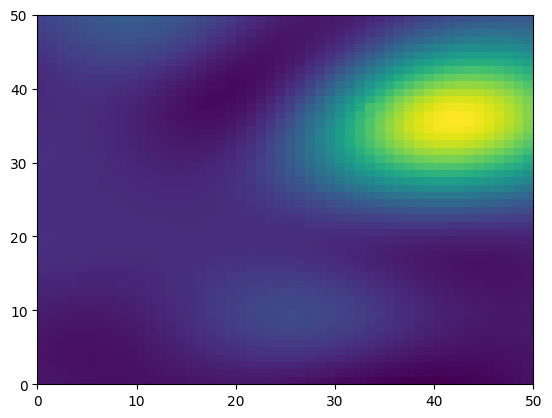

In [33]:
plt.pcolormesh(mu, cmap="viridis")

In [34]:
mu = np.linalg.solve(S,f.flatten())
mu = mu + A.dot(r_ppl/ppl2epa['err']**2)
Q = np.linalg.inv(S) + A.dot(np.transpose(A)/ppl2epa['err']**2)
mu = np.linalg.solve(Q,mu)

In [35]:
f = mu.reshape((50,50)) + intercept + slope*sim

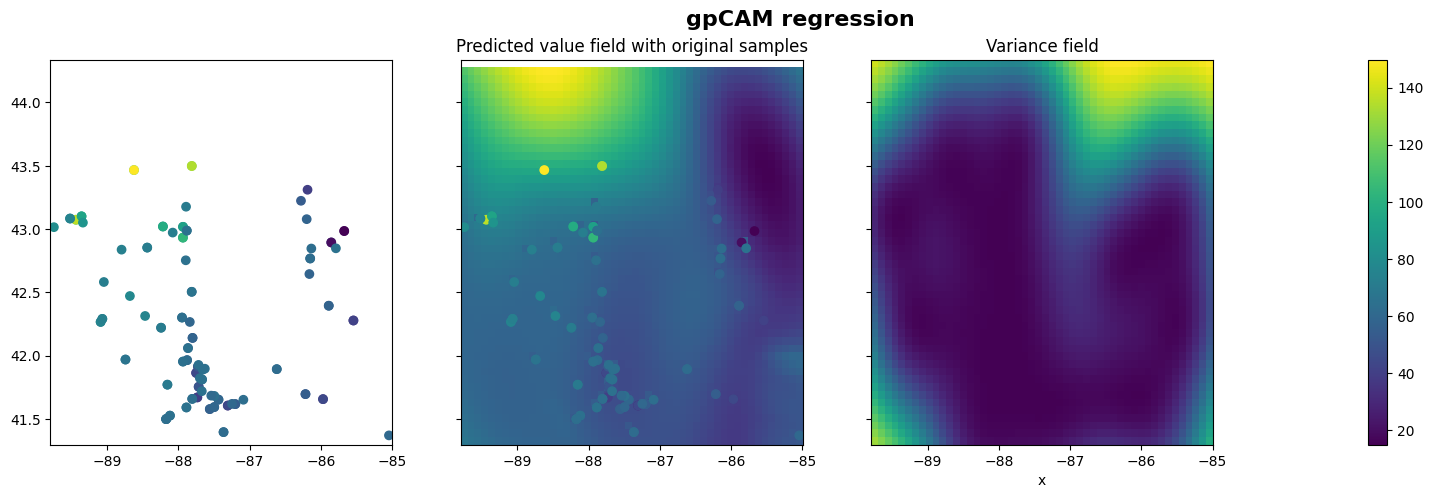

In [36]:
# Create a figure with two subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), sharex=True, sharey=True)

# Original values
axs[0].scatter(x[:,1], x[:,0], c=y, cmap="viridis")

# Predicted value field
s1 = axs[1].pcolormesh(grid['xx1'], grid['xx0'], f, cmap="viridis")
axs[1].scatter(x[:, 1], x[:, 0], c=y, cmap="viridis")
axs[1].set_title(f'Predicted value field with original samples')

# Variance field
s2 = axs[2].pcolormesh(grid['xx1'], grid['xx0'], v, cmap="viridis")
axs[2].set_title(f'Variance field')
axs[2].set_xlabel('x')

# Create a single colorbar for all subplots
fig.colorbar(s1, ax=axs, pad=0.1)  # Adjust the 'pad' parameter to change the spacing between plots and colorbar

# Set title for the entire figure
fig.suptitle(f'gpCAM regression', fontsize=16, fontweight='bold')
plt.show()

## Overlay on the Map

In [37]:
from base64 import b64encode
from io import StringIO, BytesIO
import PIL
import ipyleaflet
from ipyleaflet import Map, ImageOverlay

In [38]:
f = (f-np.min(f[~np.isnan(f)]))/(np.max(f[~np.isnan(f)])-np.min(f[~np.isnan(f)]))
f = np.transpose(f)
f = np.flipud(f)
f_im = PIL.Image.fromarray(np.uint8(plt.cm.jet(f) * 255))
im = PIL.Image.new("RGBA", f.shape, color=None)
im.paste(f_im)

In [39]:
fio = BytesIO()
im.save(fio, "png")
data = b64encode(fio.getvalue())
data = data.decode("ascii")
imgurl = "data:image/png;base64," + data

In [40]:
m = Map(center=grid['center'], zoom=7)
image = ImageOverlay(
    url=imgurl,
    bounds=((grid['sw'][0], grid['sw'][1]), (grid['ne'][0], grid['ne'][1])),
    opacity=0.3
)

m.add_layer(image);
m

Map(center=[42.8172225, -87.39416800000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…